In [149]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

In [150]:
import os
notebook_wd = os.getcwd()

In [151]:
os.chdir(os.path.join(notebook_wd, '..'))
from src.d00_utils.conf_utils import *
from src.d00_utils.data_utils import import_ms_data

In [152]:
compounds, water = load_compounds()
exp_droplet_nh3g = load_experiments(['bd_rxn_nh3g_droplet'])
exp_droplet_nh3g

{'bd_rxn_nh3g_droplet': {'paths': {'raw_data': '190924-butenedial-nh3g-droplets.csv',
   'cleaned_data': '191011-bd_rxn_nh3g_droplet-CLEANED.csv',
   'processed_data': '191011-bd_rxn_nh3g_droplet-PROCESSED.csv',
   'clustered_data': '191011-bd_rxn_nh3g_droplet-CLUSTERED.csv'},
  'experimental': {'composition': {'Butenedial': 0.75, 'PEG-6': 0.2}},
  'processing': {'solution_name': ['butenedial-peg6-181016',
    'butenedial-peg6-181018'],
   'bad_idx': None,
   'idx_range': None,
   'trap_time': None,
   'other_query': 'p283>=10000 and (solution=="butenedial-peg6-181016" or solution=="butenedial-peg6-181018") and nominal_nh3_mM==29',
   'y_col': 'mz84_mz283',
   'p283_cutoff': 30000,
   'columns_to_keep': ['trapped',
    'solution',
    'nominal_nh3_mM',
    'mz84_mz283',
    'mz85_mz283',
    'mz149_mz283']}}}

In [153]:
df_processed = import_ms_data(exp_droplet_nh3g['bd_rxn_nh3g_droplet']['paths']['processed_data'],
                             subdirectory='bd_rxn_nh3g_droplet')

df_processed.head()

,mins,solution,nominal_nh3_mM,mz84_mz283,mz85_mz283,mz149_mz283,experiment
0,18,butenedial-peg6-181018,2.9,0.076130,0.015851,0.006363,bd_nh3g_29
1,37,butenedial-peg6-181018,2.9,0.021884,0.004668,0.006950,bd_nh3g_29
2,70,butenedial-peg6-181018,2.9,0.021640,0.002487,0.008978,bd_nh3g_29
3,34,butenedial-peg6-181018,2.9,0.030922,0.008628,0.006401,bd_nh3g_29
4,13,butenedial-peg6-181018,2.9,0.019313,0.011089,0.004236,bd_nh3g_29


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 10
    # variables        = 2
    chi-square         = 0.00505747
    reduced chi-square = 6.3218e-04
    Akaike info crit   = -71.8947443
    Bayesian info crit = -71.2895741
[[Variables]]
    x10:  5 (fixed)
    x20:  0 (fixed)
    x30:  0 (fixed)
    k0:   0.12183302 +/- 0.00590992 (4.85%) (init = 0.2)
    k1:   0.77583947 +/- 0.02663943 (3.43%) (init = 0.3)
[[Correlations]] (unreported correlations are < 0.100)
    C(k0, k1) =  0.809


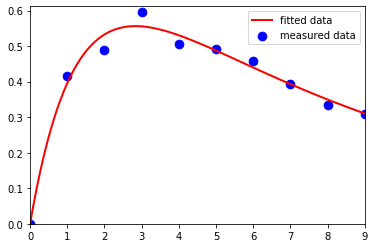

In [154]:
def f(y, t, paras):
    """
    Your system of differential equations
    """

    x1 = y[0]
    x2 = y[1]
    x3 = y[2]

    try:
        k0 = paras['k0'].value
        k1 = paras['k1'].value

    except KeyError:
        k0, k1 = paras
    # the model equations
    f0 = -k0 * x1
    f1 = k0 * x1 - k1 * x2
    f2 = k1 * x2
    return [f0, f1, f2]


def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x


def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['x10'].value, paras['x20'].value, paras['x30'].value
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model[:, 1]
    return (x2_model - data).ravel()


# initial conditions
x10 = 5.
x20 = 0
x30 = 0
y0 = [x10, x20, x30]

# measured data
t_measured = np.linspace(0, 9, 10)
x2_measured = np.array([0.000, 0.416, 0.489, 0.595, 0.506, 0.493, 0.458, 0.394, 0.335, 0.309])

plt.figure()
plt.scatter(t_measured, x2_measured, marker='o', color='b', label='measured data', s=75)

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('k0', value=0.2, min=0.0001, max=2.)
params.add('k1', value=0.3, min=0.0001, max=2.)

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(np.linspace(0., 9., 100), y0, result.params)

# plot fitted data
plt.plot(np.linspace(0., 9., 100), data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.legend()
plt.xlim([0, max(t_measured)])
plt.ylim([0, 1.1 * max(data_fitted[:, 1])])
# display fitted statistics
report_fit(result)

In [155]:
def droplet_function(y, t, coefs):
    """
    Your system of differential equations
    """

    B = y[0]
    P = y[1]
    D = y[2]

    k0 = coefs['k0'].value
    k1 = coefs['k1'].value
    k_LD = coefs['k_LD'].value
    a = coefs['a'].value
    b = coefs['b'].value
        
    k_LB = 1/(60*1.4)
    k_LP = 1/(60*4.6)
    
    # the model equations
    dBdt = -2*k0*B*B - k1*B*P - k_LB*B
    dPdt = a*(k0*B*B - k1*B*P - k_LP*P)
    dDdt = b*(k1*B*P - k_LD*D)
    
    return [dBdt, dPdt, dDdt]

In [156]:
def g(t, y0, coefs):
    """
    Solution to the ODE y'(t) = f(t,y,k) with initial condition y0
    """
    
    y = odeint(droplet_function, y0, t, args=(coefs,))
    
    return y

In [157]:
def residual(coefs, t, data):
    """
    compute the residual between actual data and fitted data
    """

    y0 = coefs['B_0'].value, coefs['P_0'].value, coefs['D_0'].value
    model = g(t, y0, coefs).T

    return (model - data).ravel()

In [163]:
B_0 = 0.033
P_0 = D_0 = 0
X_0 = [B_0, P_0, D_0]

params = Parameters()
params.add('B_0', value=B_0, vary=False)
params.add('P_0', value=P_0, vary=False)
params.add('D_0', value=D_0, vary=False)
params.add('k0', value=5, min=0, max=10.)
params.add('k1', value=5, min=0, max=10.)
params.add('k_LD', value=3.5, min=0, max=2.)
params.add('a', value=5, min=0.0001, max=20.)
params.add('b', value=3.5, min=0.0001, max=20.)

In [159]:
df_processed = df_processed.sort_values(by='mins', ascending=True)

In [160]:
ys = np.array([df_processed.mz85_mz283.values, df_processed.mz84_mz283.values, df_processed.mz149_mz283.values])

In [164]:
result = minimize(residual, params, args=(df_processed.mins.values, ys), method='leastsq')
result

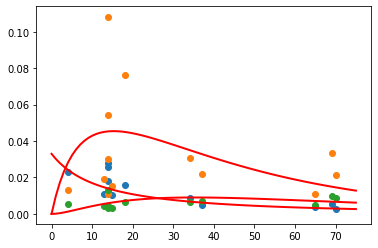

In [165]:
data_fitted = g(np.linspace(0., 75., 75), X_0, result.params)
plt.plot(np.linspace(0., 75., 75), data_fitted, '-', linewidth=2, color='red', label='fitted data')
plt.scatter(df_processed['mins'], df_processed['mz85_mz283'])
plt.scatter(df_processed['mins'], df_processed['mz84_mz283'])
plt.scatter(df_processed['mins'], df_processed['mz149_mz283'])

In [176]:
y = np.empty(0)
y = [df_processed.mz85_mz283,df_processed.mz84_mz283]
np.asarray(y).shape

(2, 13)

In [177]:
np.linspace(0, 5, 6)

array([0., 1., 2., 3., 4., 5.])